In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset and Select Ticker

In [286]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
tsla_df_raw = stock_df[stock_filt]
tsla_df_raw = tsla_df_raw.iloc[:, [7, 0, 1, 2, 3, 4, 5, 6]]
tsla_df_raw.head()

,Stock Name,Date,Open,High,Low,Close,Adj Close,Volume
0,TSLA,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000
1,TSLA,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2,TSLA,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
3,TSLA,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
4,TSLA,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400


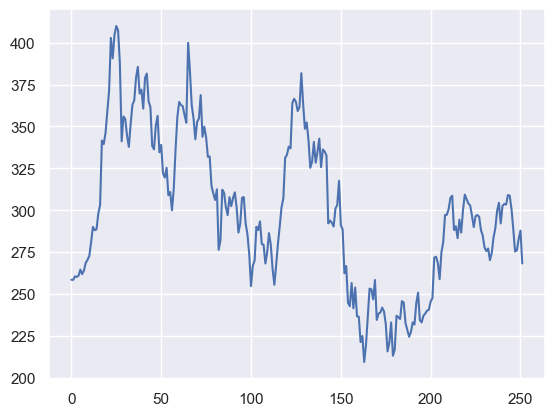

In [366]:
plt.plot(tsla_df_raw['close'].values)

### Generate Additional Features

In [311]:
tsla_df = clean_stock_data(tsla_df_raw)
tsla_df['sma'] = simple_moving_average(tsla_df)
tsla_df['ema'] = exponential_moving_average(tsla_df)
tsla_df['rsi'] = calculate_rsi(tsla_df)
tsla_df['macd_line'] , tsla_df['macd_signal'], tsla_df['macd_histogram'] = calculate_macd(tsla_df)
tsla_df['bb_middle'], tsla_df['bb_upper'], tsla_df['bb_lower'] = bollinger_bands(tsla_df)
tsla_df['target'] = calculate_closing_diff(tsla_df)

#only keep 20-end because moving avg requires window size 20
tsla_df = tsla_df[20:]
tsla_df.head()

,stock_name,date,open,high,low,close,adj_close,volume,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower,target
20,TSLA,2021-10-28,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,288.855501,299.727787,96.118171,21.687444,13.249816,8.437628,288.855501,354.015698,223.695304,13.059998
21,TSLA,2021-10-29,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,294.501834,306.547364,96.459875,24.612650,15.522383,9.090267,294.501834,367.635649,221.368019,12.320007
22,TSLA,2021-11-01,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,301.619501,315.720314,97.129203,29.139205,18.245747,10.893457,301.619501,387.433479,215.805523,31.529999
23,TSLA,2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,308.143001,322.858061,89.346741,31.380625,20.872723,10.507902,308.143001,400.300312,215.985690,-12.196686
24,TSLA,2021-11-03,392.443329,405.130005,384.206665,404.619995,404.619995,103885500,315.328168,330.644912,90.094450,33.892197,23.476617,10.415579,315.328168,414.149173,216.507162,13.953339


### Scale Features

In [ ]:
data = np.array(tsla_df[:])
data = data[:, 6:]
#store scaler for each feature so that we can unscale later
scalers = []
for i in range(0, data.shape[1]):
    sc = MinMaxScaler(feature_range=(0,1))
    data[:, i] = sc.fit_transform(data[:, i].reshape(-1, 1)).flatten()
    scalers.append(sc)

### Generate GRU train and test split

In [346]:
target = -1 #predict closing delta
#target = 0 #predict closing
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))

test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (211, 20, 12)
> Data y: (211,)
Train Set
> Data X: (181, 20, 12)
> Data y: (181,)
Test Set
> Data X: (30, 20, 12)
> Data y: (30,)


### Define Model

In [337]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [353]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=1, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2314  


In [354]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=100,
    batch_size=128
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.2145 - val_loss: 0.0337
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.5985 - val_loss: 0.1075
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0462 - val_loss: 0.1550
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1092 - val_loss: 0.1160
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0621 - val_loss: 0.0649
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0278 - val_loss: 0.0263
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0607 - val_loss: 0.0185
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0747 - val_loss: 0.0254
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0336 - val_loss: 0.0357
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0245 - val_loss: 0.0335
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0247 - val_loss: 0.0208
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0226 - val_lo

### Plot Performance

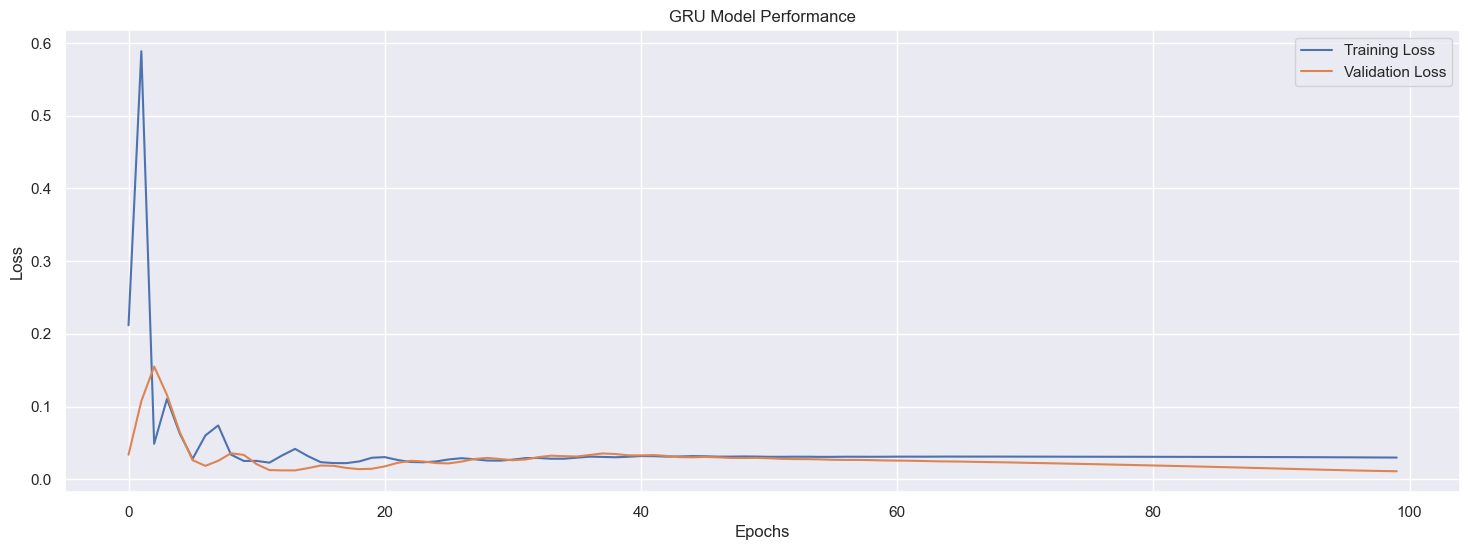

In [355]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


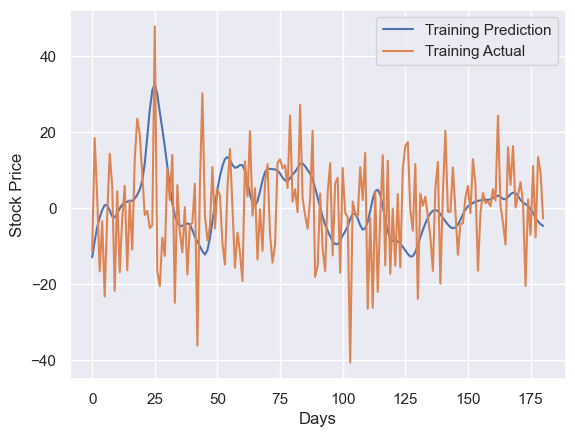

In [ ]:
train_predictions = mymodel.predict(datax_train)
train_predictions = scalers[target].inverse_transform(train_predictions)
train_actual = scalers[target].inverse_transform(datay_train.reshape(-1, 1)).flatten()
plt.plot(train_predictions, label='Training Prediction')
plt.plot(train_actual, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Stock Closing Delta')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


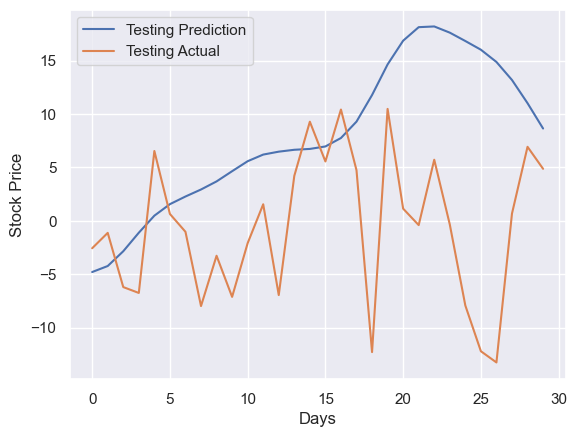

In [ ]:
test_predictions = mymodel.predict(datax_test)
test_predictions = scalers[target].inverse_transform(test_predictions)
test_actual = scalers[target].inverse_transform(datay_test.reshape(-1, 1)).flatten()
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(test_actual, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Stock Closing Delta')
plt.legend()

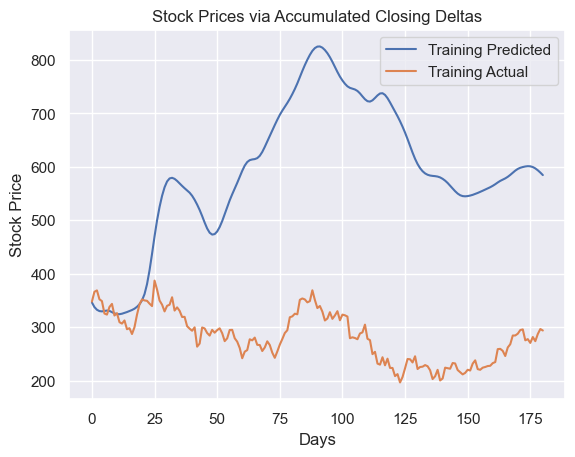

In [372]:
stock_price_train_pred = np.cumsum(train_predictions) + tsla_df['close'].iloc[0]
stock_price_train_actual = np.cumsum(train_actual) + tsla_df['close'].iloc[0]
plt.plot(stock_price_train_pred, label='Training Predicted')
plt.plot(stock_price_train_actual, label='Training Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()

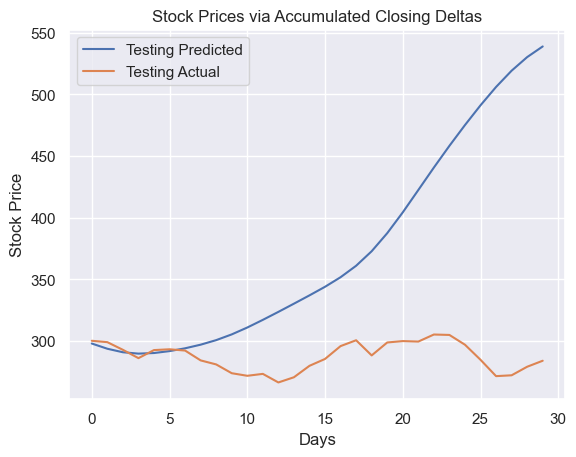

In [375]:
stock_price_test_pred = np.cumsum(test_predictions) + tsla_df['close'].iloc[-30]
stock_price_test_actual = np.cumsum(test_actual) + tsla_df['close'].iloc[-30]
plt.plot(stock_price_test_pred, label='Testing Predicted')
plt.plot(stock_price_test_actual, label='Testing Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()